In [27]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
import time;
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(63360, 2)
       

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))  
        output = output.view(output.size(0), -1)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()

In [29]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

train_dir = 'mydataset/train'
test_dir = 'mydataset/test'
validation_dir = 'validation_dataset'

# Loading and normalizing the data.
# Define transformations for the training and test sets

pretrained_size = 100


train_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                        ])

test_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                        ])

# 7410 images dans le training donc on fait 10 lots de 741 images
batch_size = 10
number_of_labels = 2 

# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_set = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

# Create a loader for the training set which will read the data within batch size and put into memory.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

print("The number of images in a training set is: ", len(train_loader)*batch_size)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = datasets.ImageFolder(root = test_dir, 
                                  transform = test_transforms)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)


print("The number of images in a test set is: ", len(test_loader)*batch_size)




validation_set = datasets.ImageFolder(root = validation_dir, 
                                  transform = test_transforms)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=0)

print("The number of images in a validation set is: ", len(validation_loader)*batch_size)


print("The number of batches per epoch is: ", len(train_loader))
classes = ('---', 'STOP')

The number of images in a training set is:  7410
The number of images in a test set is:  1880
The number of images in a validation set is:  360
The number of batches per epoch is:  741


tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
torch.Size([10, 3, 100, 133])


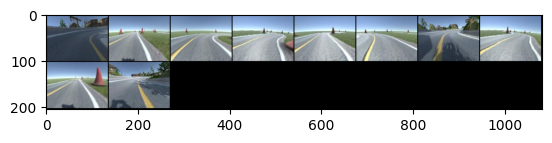

In [30]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)
# show images
print(images.shape)
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [20]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)    
    
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set

            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        print("epoch", epoch)

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

The model will be running on cuda:0 device
epoch 0
For epoch 1 the test accuracy over the whole test set is 94 %
epoch 1
For epoch 2 the test accuracy over the whole test set is 94 %


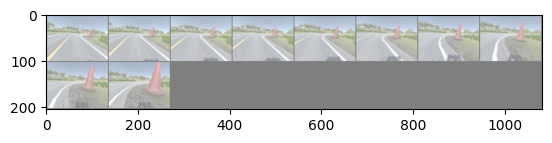

Real labels:    ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
Predicted:    ---   ---   ---   ---   ---   ---   ---   ---   ---   ---


In [22]:
if __name__ == "__main__":
    
    # Let's build our model
    train(2)

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()

In [33]:
def validationBatch():
    # get batch of images from the test DataLoader  
    total_count=0
    success1=0
    wrong1=0
    success0=0
    wrong0=0
    for i, (images, labels) in enumerate(validation_loader, 0):
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)   
            _, predicted = torch.max(outputs, 1)
            for j in range(len(predicted)):
                if predicted[j]==labels[j]:
                    if predicted[j]==0:
                        total_count+=1
                        success0+=1
                    else:
                        total_count+=1
                        success1+=1
                else:
                    if labels[j]==0:
                        total_count+=1
                        wrong0+=1
                    else:
                        total_count+=1
                        wrong1+=1
                    

    print("total count: ",total_count)
    print("success1: ",success1)
    print("wrong1: ", wrong1)
    print("success0:", success0)
    print("wrong0: ",wrong0)

   
    # Show the real labels on the screen 
    print("Reality: ",labels)
    
    # Let's see what if the model identifiers the  labels of those example
    # We got the probability for every 10 labels. The highest (max) probability should be correct label

    print("Predicted",predicted)
    
    # Let's show the predicted labels on the screen to compare with the real ones

    
model = Network().to(device)
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))
validationBatch()

total count:  358
success1:  0
wrong1:  67
success0: 288
wrong0:  3
Reality:  tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
